In [1]:
import numpy as np
import numpy as np
import matplotlib.pyplot as plt
from scipy.sparse import dok_matrix, coo_matrix, vstack
from scipy.sparse.linalg import lsqr

In [2]:
def construct_X(M, alphas, Np=None, tau=0):
    D = M*M
    # define sensor size
    if Np is None:
        Np = int(np.ceil(np.sqrt(2) * M))
    
    if Np % 2 == 0: 
        Np += 1
    
    # number of angles
    No = len(alphas)

    # flattened output coordinates
    j = np.mgrid[0:D].astype(np.int32)
    # coordinate matrix for the output pixels
    M2 = (M-1) / 2
    grid = np.mgrid[-M2:M-M2,-M2:M-M2].swapaxes(1,2).reshape(2,D)

    # collect indices and corresponding values for all iterations
    i_indices = []
    j_indices = []
    weights = []

    for k, alpha in enumerate(alphas):
    # convert angle and prepare projection vector
        alph_rad = np.radians(alpha)
        proj_vec = np.array([np.cos(alph_rad), -np.sin(alph_rad)])
        
        # project coordinates
        proj = np.dot(proj_vec, grid) + Np // 2
        
        # compute sensor indices and weights below the projected points
        i = np.floor(proj)
        w = (i+1) - proj
        
        # make sure rays falling outside the sensor are not counted
        clip = np.logical_and(0 <= i, i < Np-1)
        i_indices.append((i + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])

        # compute sensor indices and weights above the projected points
        w = proj - i
        i_indices.append((i+1 + k*Np)[clip])
        j_indices.append(j[clip])
        weights.append(w[clip])
    
    # construct matrix X
    i = np.concatenate(i_indices).astype(np.int32)
    j = np.concatenate(j_indices).astype(np.int32)
    w = np.concatenate(weights)
    X = coo_matrix((w, (i,j)), shape = (No*Np, D), dtype = np.float32)
    
    if tau != 0:
        i = np.arange(D)
        j = np.arange(D)
        print("X shape", X.shape)
        X_prime = vstack([
            X,
            coo_matrix((D * [np.sqrt(tau)], (i, j)), shape=(D, D), dtype=np.float32)
        ])
    
        print("X' shape", X_prime.shape)
        return X_prime
    
    
    return X

In [3]:
alphas = np.load("../ex05/hs_tomography/alphas_195.npy", allow_pickle=True)
y = np.load("../ex05/hs_tomography/y_195.npy", allow_pickle=True)

In [4]:
y = y.reshape((len(alphas), len(y)// len(alphas)))

In [5]:
# only use 64 projections
alphas = alphas[:64]
y = y[:64].flatten()

In [6]:
taus = [0, 1, 10, 100, 1000, 10000]

M = len(alphas)
D = M*M
Xs = [construct_X(M, alphas, tau=tau) for tau in taus]

# extend y with D zeros
print("y shape", y.shape)
y = np.hstack([y, np.zeros((D), dtype=np.float32)])
print("new y shape", y.shape)


X shape (5824, 4096)
X' shape (9920, 4096)
X shape (5824, 4096)
X' shape (9920, 4096)
X shape (5824, 4096)
X' shape (9920, 4096)
X shape (5824, 4096)
X' shape (9920, 4096)
X shape (5824, 4096)
X' shape (9920, 4096)
y shape (17600,)
new y shape (21696,)


In [7]:
beta = lsqr(Xs[0], y, atol = 1e-5, btol = 1e-5)[0]

ValueError: dimension mismatch

In [ ]:
Xs[0].shape, y.shape

In [14]:
del y_sub

[0]


ValueError: dimension mismatch

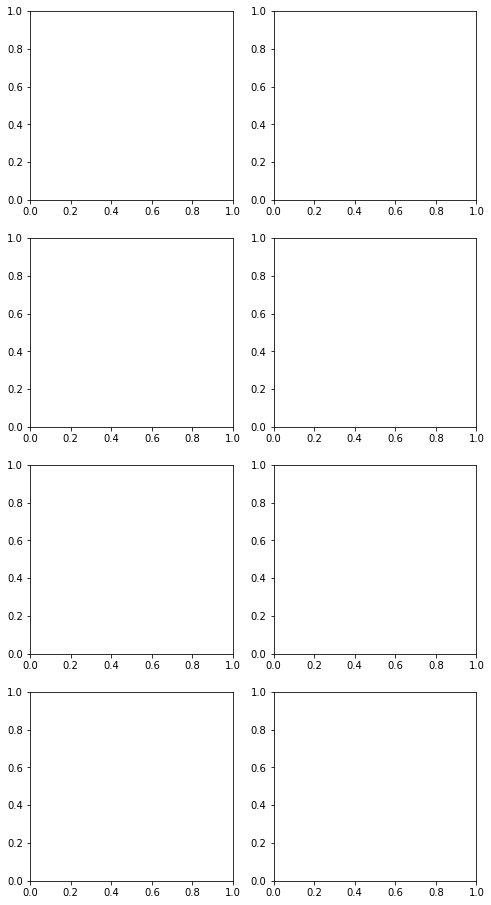

In [15]:
# set up data
Np = 275
y = np.load('../ex05/hs_tomography/y_195.npy')
alphas = np.load('../ex05/hs_tomography/alphas_195.npy')
# numbers of projection angles to test
n_projections = [1, 2, 4, 8, 16, 32, 48, 64]
fig, axes = plt.subplots(4, 2, figsize = (8,16))

for n, n_projection in enumerate(n_projections):
 # pick specified number of angles
    index = [int(np.ceil(len(alphas) * p/n_projection)) for p in range(n_projections[n])]
    
    alphas_sub = alphas[index]
 # collect corresponding measurements from y
    y_sub = []
    for i in index:
        y_sub.extend(y[i*Np : (i+1)*Np])
 
    # construct matrix and reconstruct image
    X = construct_X(195, alphas_sub, Np).tocsc()
    beta = lsqr(X, np.array(y_sub), atol = 1e-5, btol = 1e-5)[0].reshape(195,195)
# plot image
    axes.flat[n].imshow(beta, vmin = 0, vmax = 255, interpolation = 'nearest')
    axes.flat[n].set_title('{} projections'.format(n_projections[n])); axes.flat[n].axis('off')
fig.tight_layout()
plt.show()

In [10]:
y.shape, X.shape

((49225,), (17600, 38025))

In [12]:
len(y_sub)

17600